<a href="https://colab.research.google.com/github/takaito1/EAS4821_S2024/blob/main/scripts/week10_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week10 exercise - Fourier transform

- Learning goals
- Understand how to use basic functions of fft package (fft, ifft, fftfreq)
- Understand the output
- Display results
- Develop a band-pass filter data using FFT

In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq, fft2, ifft2
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/EAS2655_4821/atlanta.csv',index_col=0)
df

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
YEAR,,,,,,,,,,,,,
1879,44.3,43.7,57.6,58.9,69.8,74.9,79.6,73.9,68.7,64.3,53.9,51.5,61.8
1880,54.3,51.4,55.5,63.4,71.0,76.5,79.2,76.8,69.4,60.8,47.2,42.1,62.3
1881,40.1,46.6,49.1,59.1,70.8,77.8,81.1,78.8,75.5,67.2,52.6,49.6,62.4
1882,48.8,52.4,57.4,64.8,66.1,76.6,75.9,75.8,71.7,65.8,51.1,41.4,62.3
1883,43.0,50.2,50.2,61.6,67.4,76.4,80.1,76.2,71.3,66.0,53.7,48.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,45.9,53.8,55.4,65.3,76.4,77.7,82.2,82.5,82.4,68.4,52.5,51.2,66.1
2020,49.2,49.9,61.6,61.6,68.9,76.8,82.1,80.9,73.8,67.3,58.9,46.1,64.8
2021,46.2,48.7,59.1,62.9,69.7,77.6,79.9,80.4,73.9,67.2,52.9,56.0,64.5


Text(0, 0.5, 'July temperature, deg F')

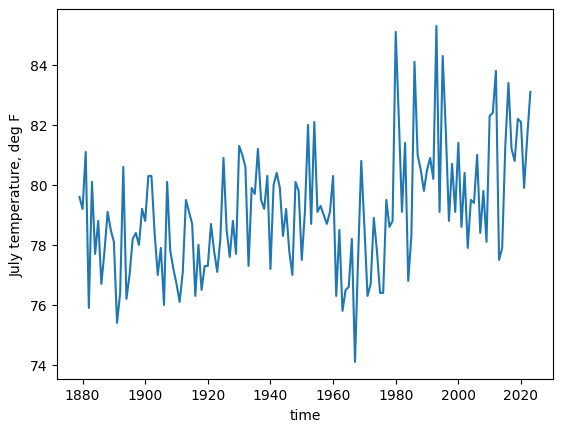

In [4]:
# get input data : july temperature
year = df.index.to_numpy()
T = df['JUL'].to_numpy()
plt.plot(year,T)
plt.xlabel('time')
plt.ylabel('July temperature, deg F')

In [5]:
# Apply FFT
Tw = fft(T)
dt = 1 # sampling time interval
N = np.size(T) # calculate sample size
#
print('Sample size is '+str(N))
freq = fftfreq(N,dt) # cycle per unit time
#
print('Nyquist (fastest) frequency is '+str((2*dt))+' year periodicity')
print('3 slowest frequencyies are '+str(1/freq[1:4])+' year periodicity')

Sample size is 145
Nyquist (fastest) frequency is 2 year periodicity
3 slowest frequencyies are [145.          72.5         48.33333333] year periodicity


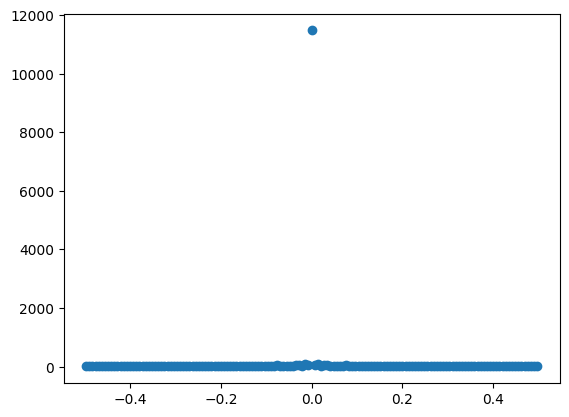

In [6]:
# A quick look at the FFT output
plt.plot(freq,np.abs(Tw),'o')

Text(0.5, 1.0, 'Periodogram of July Atlanta temperature')

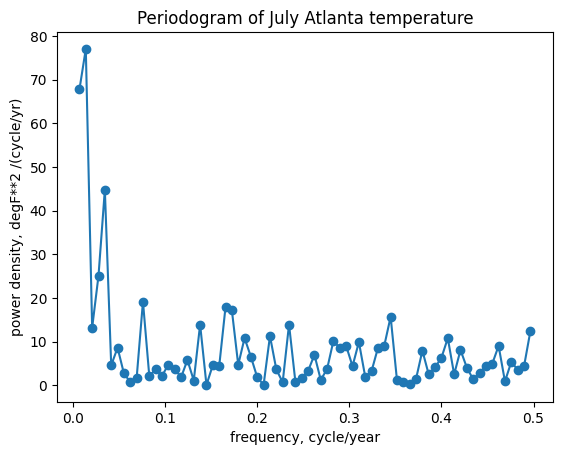

In [7]:
## calculate power spectral density and plot it
#
#    exclude the mean value (n=0)
#    take positive frequencies only and multiply by a factor of 2
PSD = (np.abs(Tw))**2/N
freq1 = freq[freq>0]
PSD1 = PSD[freq>0]*2
#
plt.plot(freq1,PSD1,'o-')
plt.xlabel('frequency, cycle/year')
plt.ylabel('power density, degF**2 /(cycle/yr)')
plt.title('Periodogram of July Atlanta temperature')

In [8]:
# Application of Perseval's theorem
#
# calculate the fraction of variance contained in less than 2-10 year timescale
selband=(freq1>=1/10)&(freq1<=2)
fracvar = np.sum(PSD1[selband])/np.sum(PSD1)*100
print(str(fracvar)[:4]+' percent of variance is contained in 2-10 year timescale')
#

54.5 percent of variance is contained in 2-10 year timescale


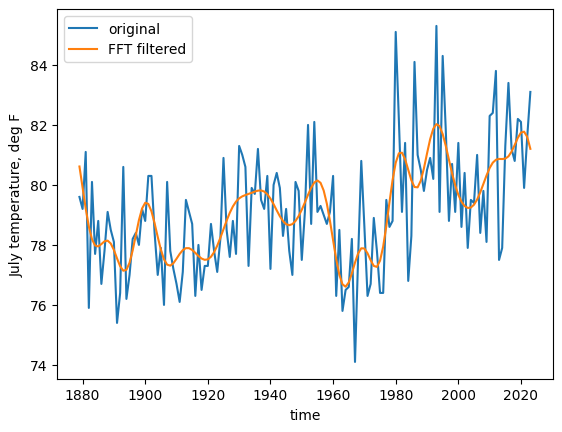

In [9]:
# Apply band-pass filter
#
# filter out the 2-10 year timescale
selband=(np.abs(freq)>=1/10)&(np.abs(freq)<=1/2)
Tw_filtered = Tw.copy()
Tw_filtered[selband]=0 # filter out the selected frequency
#
T_filtered = np.real(ifft(Tw_filtered)) # inverse transform back to time domain
#
plt.plot(year,T,label='original')
plt.plot(year,T_filtered,label='FFT filtered')
plt.xlabel('time')
plt.ylabel('July temperature, deg F')
plt.legend()

In [10]:
## Re-calculating the variance in time domain
var_full = np.var(T)
print(var_full)
var_filtered = np.var(T_filtered)
print(var_filtered)
#
print('Fraction of variance in the filtered data (in time domain) is '+str(var_filtered/var_full*100)[:5]+' percent')

4.144678240190248
1.8854172357858667
Fraction of variance in the filtered data (in time domain) is 45.49 percent


In [11]:
# Use NCEP-reanalysis data
ds=xr.open_dataset('/content/drive/MyDrive/EAS2655_4821/air.2m.mon.mean.nc')

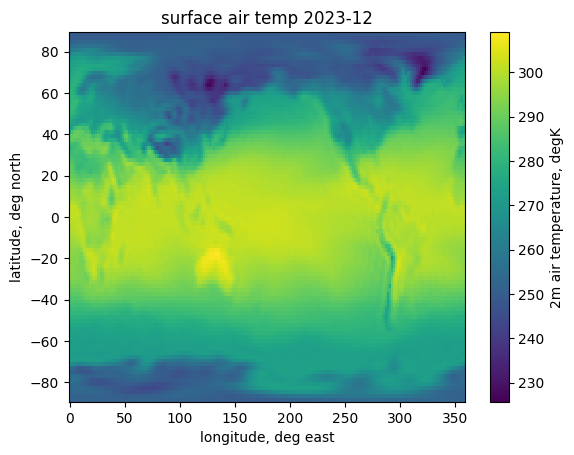

In [12]:
# extract Decemner 2023 temperature, longitude and latitude
T = ds.air.sel(time='2023-12',method='nearest').to_numpy()
x=ds.lon.to_numpy()
y=ds.lat.to_numpy()
# quick look at the data
im=plt.pcolormesh(x,y,T)
plt.xlabel('longitude, deg east')
plt.ylabel('latitude, deg north')
plt.title('surface air temp 2023-12')
plt.colorbar(label='2m air temperature, degK')

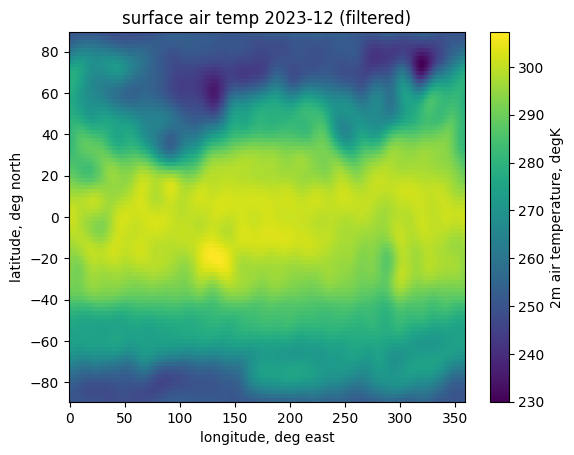

In [13]:
# Apply 2D FFT, and get x and y frequencies (wave numbers)
Tfft2 = fft2(T)
yfreq = fftfreq(T.shape[0],1.9)
xfreq = fftfreq(T.shape[1],1.9)
#
# filter out small scale (less than 20 deg lon/lat)
xx,yy=np.meshgrid(xfreq,yfreq)
tfreq = np.sqrt(xx**2 + yy**2)
selband=(tfreq>1/20)
Tfft2[selband]=0
#
# inverse transform back to real space
Tfilt = ifft2(Tfft2)
#
# display result
im=plt.pcolormesh(x,y,np.real(Tfilt))
plt.xlabel('longitude, deg east')
plt.ylabel('latitude, deg north')
plt.title('surface air temp 2023-12 (filtered)')
plt.colorbar(label='2m air temperature, degK')